In [1]:
!pip install python-chess
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=ed7f1d0a744f19644e1fc81711e83ab611f4dd29068c52486d4674d980290bdd
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import chess
import random
import time
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import chess.engine
import chess.pgn
%matplotlib inline

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

In [3]:
class ChessBot:
    def __init__(self):
        self.board = chess.Board()
        self.discount_factor = 0.9
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.episode_rewards = []
        self.memory = []  # Replay memory for experience replay
        self.batch_size = 64
        self.memory_capacity = 10000  # Maximum size of replay memory
        self.model = self.build_model()
        self.target_model = self.build_model()  # Target network for stable training

    def build_model(self):
        """Build a neural network to approximate Q-values."""
        model = models.Sequential([
            layers.Input(shape=(64,)), # Input: 64 squares
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)  # Output: Q-value for a given action
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def load_pgn_games(self, pgn_file, max_games):
        """Load moves from PGN file into the DeepQ model."""
        if not os.path.exists(pgn_file):
            raise FileNotFoundError(f"PGN file '{pgn_file}' not found. Did you run the download code?")
        game_count = 0
        games = []
        update_interval = 1000
        with open(pgn_file) as f:
            while True:
              try:
                    game = chess.pgn.read_game(f)
                    if game is None:
                        break  # End of file
                    # Loading Progress
                    game_count += 1
                    if game_count % update_interval == 0:
                        print(f"Processed {game_count} games... (Current FEN count: {len(self.policy)})")
                    if game_count >= max_games:
                        break # Max games reached
                    board = game.board()
                    for move in game.mainline_moves():
                        state = self.get_state(board)
                        action = move
                        fen = board.fen()
                        board.push(move) # advance with move
                        reward = self.get_reward(board)
                        next_state = self.get_state(board)
                        if (len(self.memory) < self.memory_capacity):
                          self.memory.append((state, action, reward, next_state, board.is_game_over()))
              except Exception as e:
                    print(f"Skipping corrupt game {game_count + 1}. Error: {e}")
                    continue
            print(f"Finished loading {game_count} games.")

    def get_state(self, board):
        """Convert the board state to a numerical representation."""
        state = np.zeros(64)  # 8x8 board
        for i in range(64):
            piece = board.piece_at(i)
            if piece:
                state[i] = self.piece_to_value(piece)
        return state

    def piece_to_value(self, piece):
        """Convert a chess piece to a numerical value."""
        piece_values = {
            chess.PAWN: 1,
            chess.KNIGHT: 3,
            chess.BISHOP: 3,
            chess.ROOK: 5,
            chess.QUEEN: 9,
            chess.KING: 100
        }
        return piece_values.get(piece.piece_type, 0) * (1 if piece.color == chess.WHITE else -1)

    def get_reward(self, board):
        """Define the reward function for a given board state."""
        if board.is_checkmate():
            return 100 if board.turn == chess.BLACK else -100
        elif board.is_stalemate() or board.is_insufficient_material():
            return 0
        else:
            return 1  # Reward for non-terminal states

    def choose_action(self, board):
        """Choose an action using an epsilon-greedy policy."""
        if random.random() < self.epsilon:
            # Explore: choose a random legal move
            return random.choice(list(board.legal_moves))
        else:
            # Exploit: choose the action with the highest Q-value
            state = self.get_state(board)
            q_values = {}
            for action in board.legal_moves:
                next_state = self.get_state(board.copy(stack=False))
                next_state[action.to_square] = self.piece_to_value(board.piece_at(action.from_square))
                q_values[action] = self.model.predict(np.array([next_state]), verbose=0)[0][0]
            return max(q_values, key=q_values.get)

    def train_q_learning(self, num_episodes=1000):
        """Train the bot using neural network-based Q-learning."""
        for episode in range(num_episodes):
            self.board.reset()
            total_reward = 0  # Track total reward for the episode
            while not self.board.is_game_over():
                state = self.get_state(self.board)
                action = self.choose_action(self.board)
                self.board.push(action)
                next_state = self.get_state(self.board)
                reward = self.get_reward(self.board)
                total_reward += reward

                # Store experience in replay memory
                self.memory.append((state, action, reward, next_state, self.board.is_game_over()))
                if len(self.memory) > self.memory_capacity:
                    self.memory.pop(0)

                # Train the neural network using experience replay
                if len(self.memory) >= self.batch_size:
                    self.replay()

            # Decay epsilon to reduce exploration over time
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Store the total reward for this episode
            self.episode_rewards.append(total_reward)

            print(f"Episode {episode + 1}/{num_episodes} completed. Epsilon: {self.epsilon:.4f}")

        # Plot the rewards over time after training
        self.plot_rewards()

    def replay(self):
        """Train the neural network using experience replay."""
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([experience[0] for experience in batch])
        actions = [experience[1] for experience in batch]
        rewards = np.array([experience[2] for experience in batch])
        next_states = np.array([experience[3] for experience in batch])
        dones = np.array([experience[4] for experience in batch])

        # Predict Q-values for the next states
        next_q_values = self.target_model.predict(next_states, verbose=0).flatten()

        # Compute target Q-values
        targets = rewards + self.discount_factor * next_q_values * (1 - dones)

        # Update the neural network
        self.model.fit(states, targets, epochs=1, verbose=0)

        # Update the target network periodically
        if len(self.memory) % 100 == 0:
            self.target_model.set_weights(self.model.get_weights())

    def plot_rewards(self):
        """Plot the rewards obtained over time during training."""
        plt.plot(self.episode_rewards, label="Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Rewards Obtained Over Time")
        plt.legend()
        plt.grid()
        plt.show()

    def auto_game(self):
        """The bot plays a game against itself."""
        self.board.reset()
        print("Starting self-play game...")

        while not self.board.is_game_over():
            print("\nCurrent board:")
            display(self.board)
            print("------")

            # Bot's turn (for both sides)
            state = self.get_state(self.board)
            q_values = {}
            for action in self.board.legal_moves:
                next_state = self.get_state(self.board.copy(stack=False))
                next_state[action.to_square] = self.piece_to_value(self.board.piece_at(action.from_square))
                q_values[action] = self.model.predict(np.array([next_state]), verbose=0)[0][0]
            move = max(q_values, key=q_values.get)

            print(f"Move {self.board.fullmove_number}: {self.board.san(move)}")
            self.board.push(move)

        print("\nFinal board:")
        display(self.board)
        print("Game over. Result:", self.board.result())

    def play_game(self):
        """Play a game against a human player."""
        self.board.reset()
        print("You are playing as White.")
        print("Enter your moves in UIC format (e.g., e2e4, g1f3).")

        while not self.board.is_game_over():
            print("\nCurrent board:")
            display(self.board)
            time.sleep(1) # wait for input field to render
            print("------")

            if self.board.turn == chess.WHITE:
                # Human player's turn
                move_uci = input("Your move (in UCI format, e.g., e2e4): ")
                try:
                    move = chess.Move.from_uci(move_uci)
                    if move in self.board.legal_moves:
                        self.board.push(move)
                    else:
                        print("Illegal move. Try again.")
                        continue
                except ValueError:
                    print("Invalid input format. Try again.")
                    continue
            else:
                # Bot's turn
                state = self.get_state(self.board)
                q_values = {}
                for action in self.board.legal_moves:
                    next_state = self.get_state(self.board.copy(stack=False))
                    next_state[action.to_square] = self.piece_to_value(self.board.piece_at(action.from_square))
                    q_values[action] = self.model.predict(np.array([next_state]), verbose=0)[0][0]
                move = max(q_values, key=q_values.get)

                print(f"Bot's move: {self.board.san(move)}")
                self.board.push(move)

        print("\nFinal board:")
        display(self.board)
        print("Game over. Result:", self.board.result())

    def save(self, filename="deep_q_bot.pkl"):
        """Save the bot's state to a file."""
        # Save the neural network model
        self.model.save("deep_q_model.keras")
        # Save other attributes
        with open(filename, "wb") as f:
            pickle.dump({
                "discount_factor": self.discount_factor,
                "learning_rate": self.learning_rate,
                "epsilon": self.epsilon,
                "epsilon_decay": self.epsilon_decay,
                "epsilon_min": self.epsilon_min,
                "episode_rewards": self.episode_rewards,
                "memory": self.memory,
                "batch_size": self.batch_size,
                "memory_capacity": self.memory_capacity
            }, f)
        print(f"Bot saved to {filename} and deep_q_model.keras, remember to download them from the colab files before terminating runtime")

    def load(self, filename="deep_q_bot.pkl"):
        """Load the bot's state from a file."""
        # Load the neural network model
        self.model = tf.keras.models.load_model("deep_q_model.keras")
        # Load other attributes
        with open(filename, "rb") as f:
            data = pickle.load(f)
            self.discount_factor = data["discount_factor"]
            self.learning_rate = data["learning_rate"]
            self.epsilon = data["epsilon"]
            self.epsilon_decay = data["epsilon_decay"]
            self.epsilon_min = data["epsilon_min"]
            self.episode_rewards = data["episode_rewards"]
            self.memory = data["memory"]
            self.batch_size = data["batch_size"]
            self.memory_capacity = data["memory_capacity"]
        print(f"Bot loaded from {filename} and deep_q_model.keras")

In [4]:
# Run this if you have a saved bot file
# Upload the bot file into the colab files
bot = ChessBot()
bot.load()

Bot loaded from deep_q_bot.pkl and deep_q_model.keras


In [ ]:
# bot.load_pgn_games('./lichess_study_endgames-database_by_pietro2009_2021.07.06.pgn', 10000)

Finished loading 29 games.


In [ ]:
# Run this if you need to train a new bot
# Download the files created from the colab files before terminating runtime
train_new = False
if train_new:
  bot = ChessBot()
bot.train_q_learning(num_episodes=100)
bot.save()

Episode 1/100 completed. Epsilon: 0.8142
Episode 2/100 completed. Epsilon: 0.8102
Episode 3/100 completed. Epsilon: 0.8061
Episode 4/100 completed. Epsilon: 0.8021
Episode 5/100 completed. Epsilon: 0.7981
Episode 6/100 completed. Epsilon: 0.7941
Episode 7/100 completed. Epsilon: 0.7901
Episode 8/100 completed. Epsilon: 0.7862
Episode 9/100 completed. Epsilon: 0.7822
Episode 10/100 completed. Epsilon: 0.7783
Episode 11/100 completed. Epsilon: 0.7744
Episode 12/100 completed. Epsilon: 0.7705
Episode 13/100 completed. Epsilon: 0.7667
Episode 14/100 completed. Epsilon: 0.7629
Episode 15/100 completed. Epsilon: 0.7590
Episode 16/100 completed. Epsilon: 0.7553
Episode 17/100 completed. Epsilon: 0.7515
Episode 18/100 completed. Epsilon: 0.7477
Episode 19/100 completed. Epsilon: 0.7440
Episode 20/100 completed. Epsilon: 0.7403
Episode 21/100 completed. Epsilon: 0.7366
Episode 22/100 completed. Epsilon: 0.7329
Episode 23/100 completed. Epsilon: 0.7292
Episode 24/100 completed. Epsilon: 0.7256
E

In [ ]:
from google.colab import files
files.download("./deep_q_model.keras")
files.download("./deep_q_bot.pkl")

Starting self-play game...

Current board:


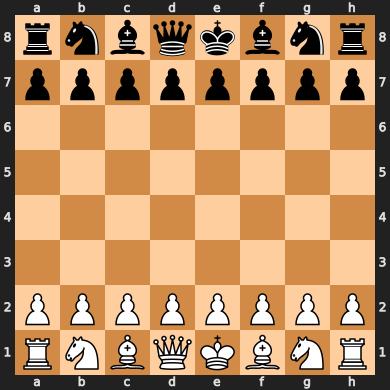

------
Move 1: Nc3

Current board:


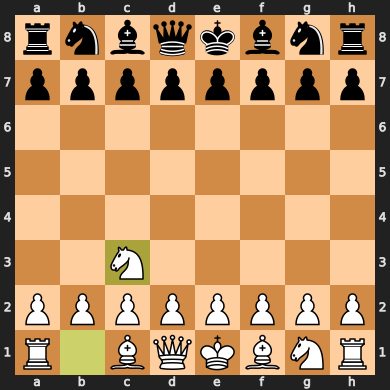

------
Move 1: Nf6

Current board:


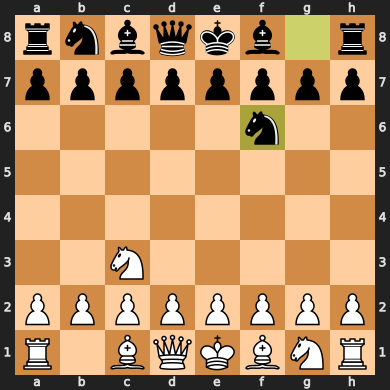

------
Move 2: Rb1

Current board:


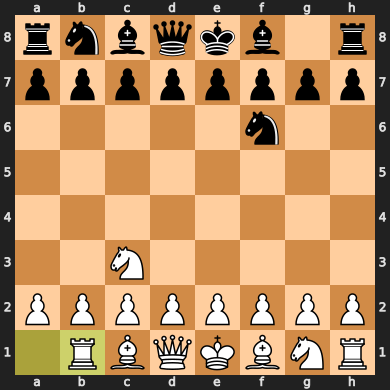

------
Move 2: Nc6

Current board:


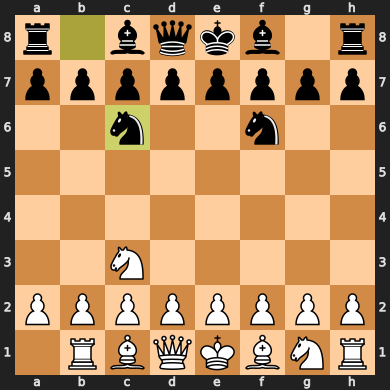

------
Move 3: Ne4

Current board:


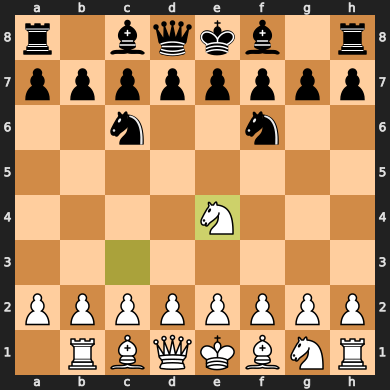

------
Move 3: Rb8

Current board:


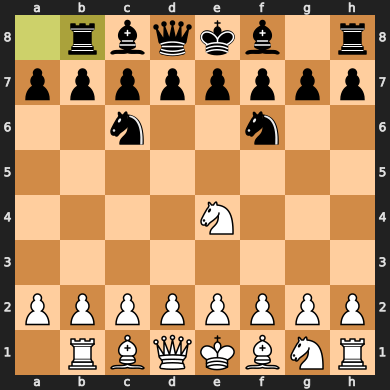

------
Move 4: Ng3

Current board:


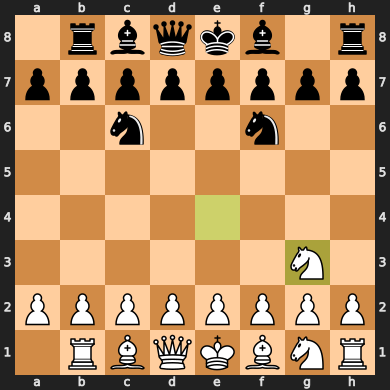

------
Move 4: Ra8

Current board:


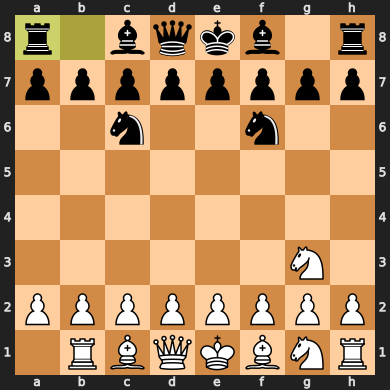

------
Move 5: Ne4

Current board:


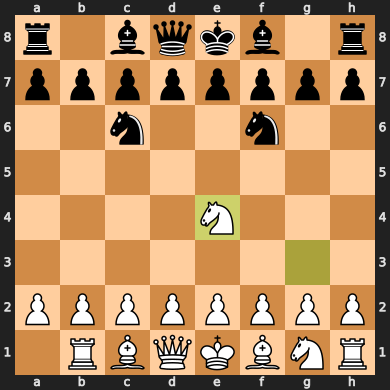

------
Move 5: Rb8

Current board:


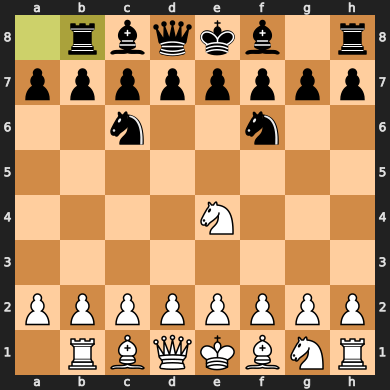

------
Move 6: Ng3

Current board:


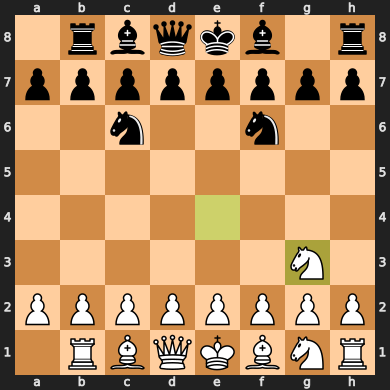

------
Move 6: Ra8

Current board:


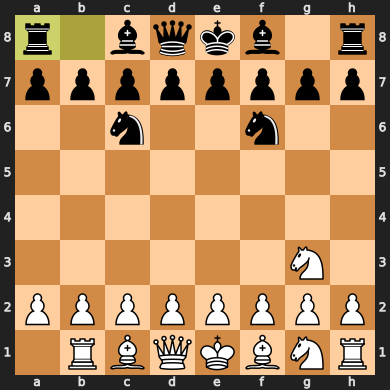

------
Move 7: Ne4

Current board:


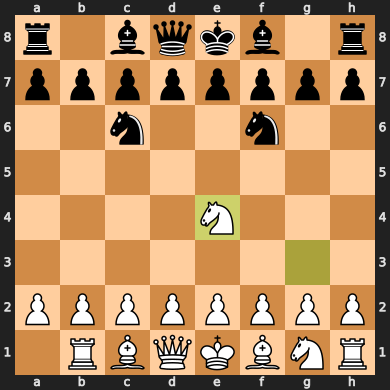

------
Move 7: Rb8

Current board:


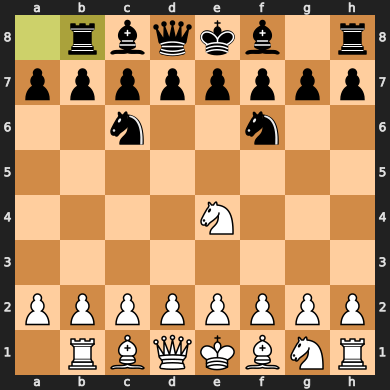

------
Move 8: Ng3

Current board:


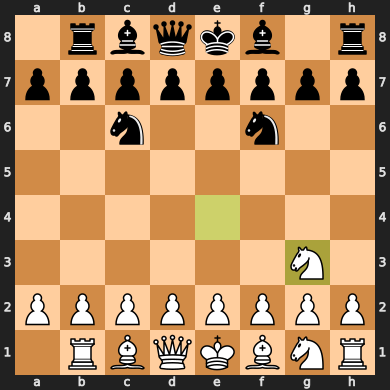

------
Move 8: Ra8

Current board:


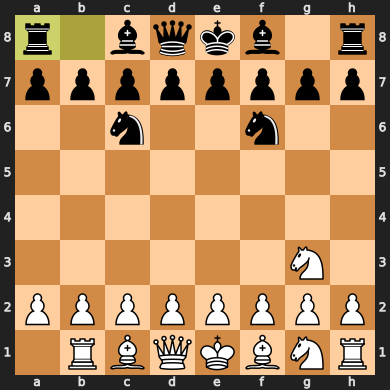

------
Move 9: Ne4

Current board:


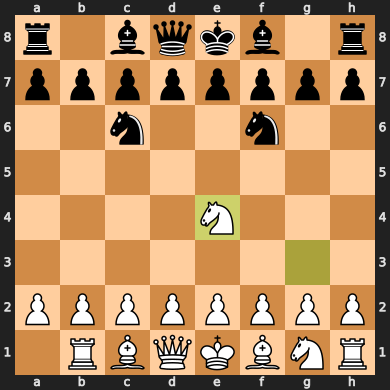

------
Move 9: Rb8

Current board:


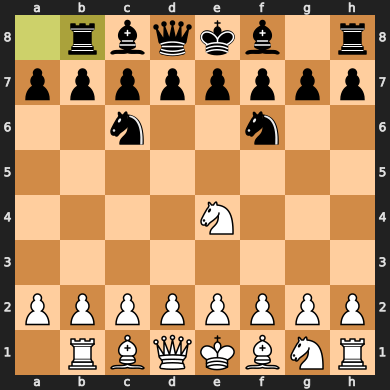

------
Move 10: Ng3

Current board:


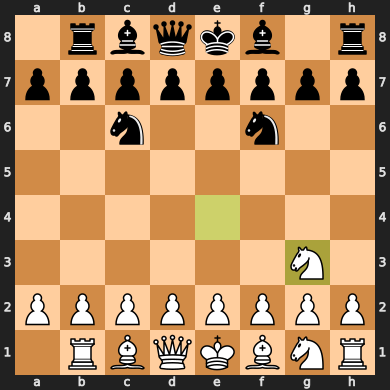

------
Move 10: Ra8

Current board:


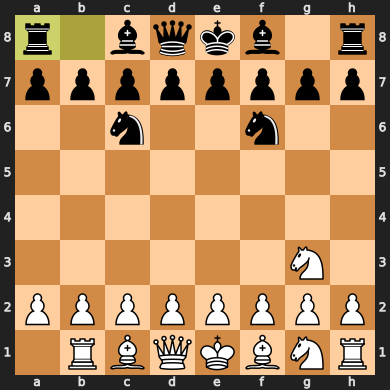

------
Move 11: Ne4

Current board:


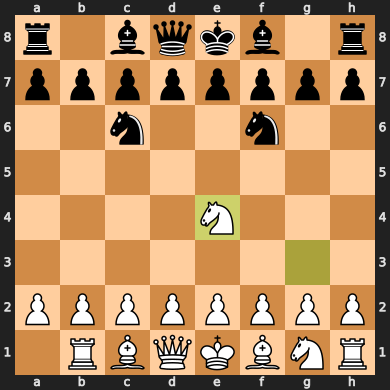

------
Move 11: Rb8

Final board:


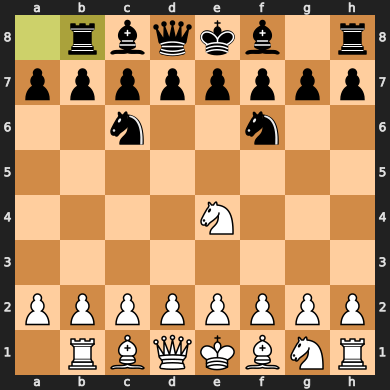

Game over. Result: 1/2-1/2


In [5]:
# Bot plays against itself
bot.auto_game()

You are playing as White.
Enter your moves in UIC format (e.g., e2e4, g1f3).

Current board:


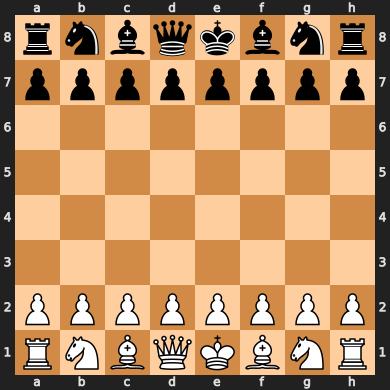

------
Your move (in UCI format, e.g., e2e4): e2e3

Current board:


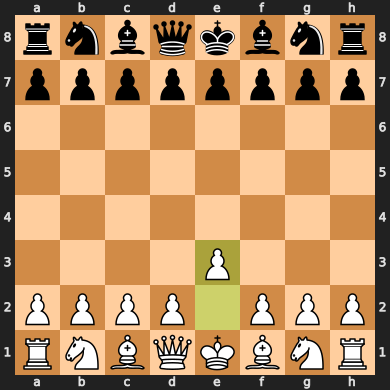

------
Bot's move: Nf6

Current board:


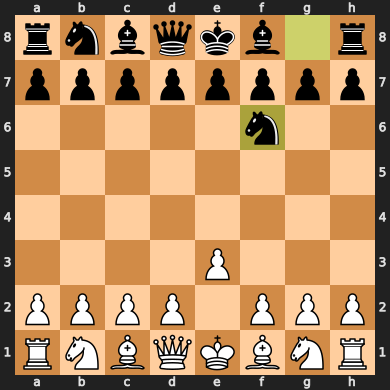

------
Your move (in UCI format, e.g., e2e4): e3e4

Current board:


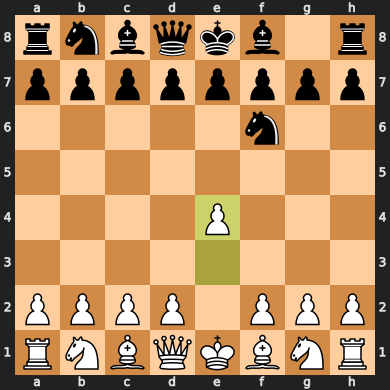

------
Bot's move: Nc6

Current board:


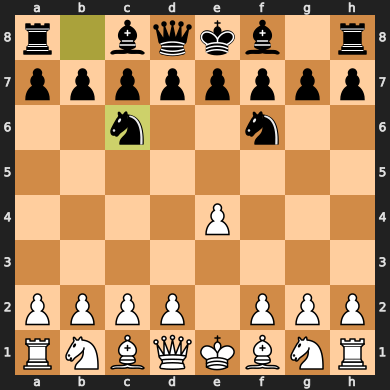

------
Your move (in UCI format, e.g., e2e4): h2h3

Current board:


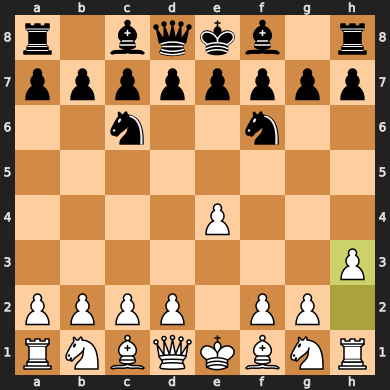

------
Bot's move: Rb8

Current board:


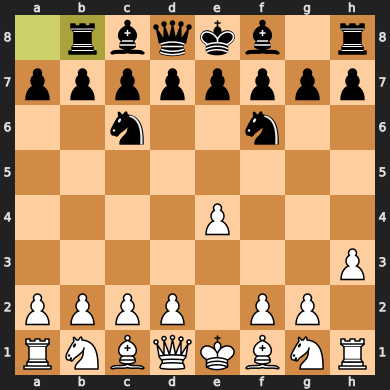

------
Your move (in UCI format, e.g., e2e4): h3h4

Current board:


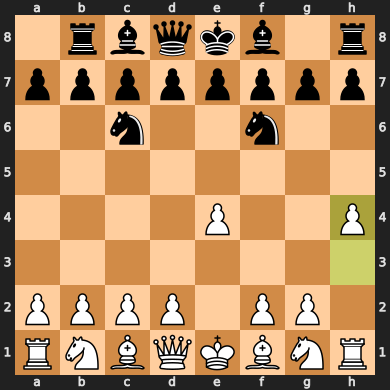

------
Bot's move: Ra8

Current board:


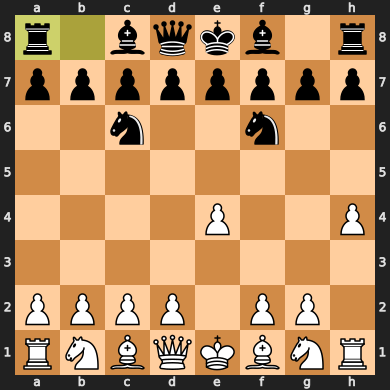

------
Your move (in UCI format, e.g., e2e4): h1h3

Current board:


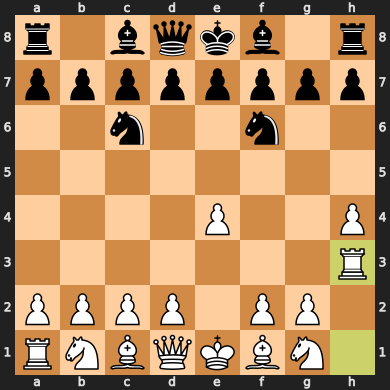

------
Bot's move: Rb8

Current board:


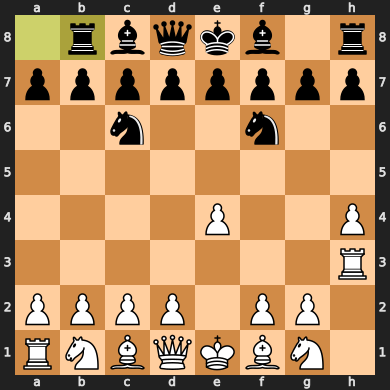

------
Your move (in UCI format, e.g., e2e4): h3c6
Illegal move. Try again.

Current board:


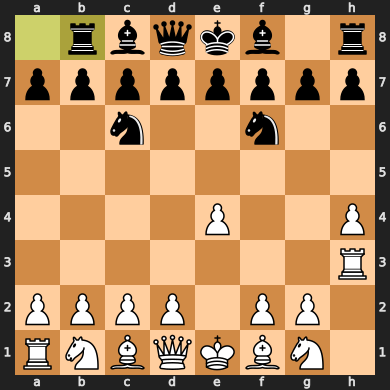

------
Your move (in UCI format, e.g., e2e4): h3c3

Current board:


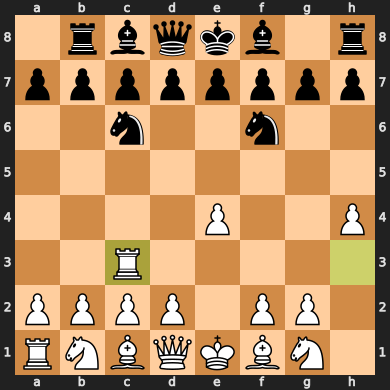

------
Bot's move: Ra8

Current board:


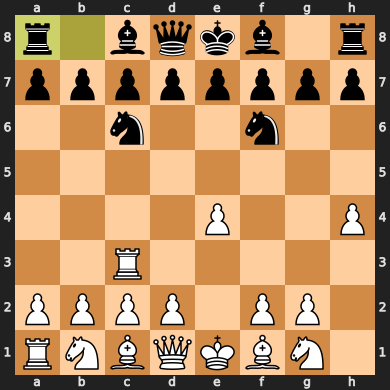

------
Your move (in UCI format, e.g., e2e4): c3c6

Current board:


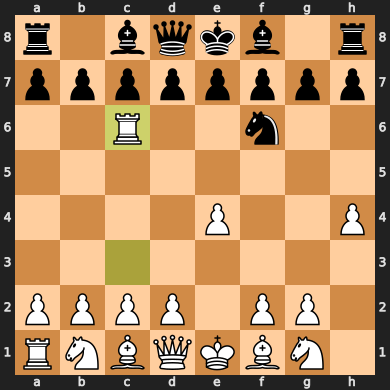

------
Bot's move: Rb8

Current board:


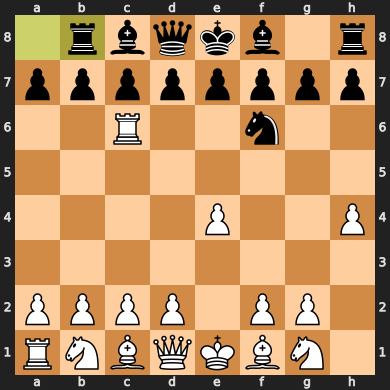

------
Your move (in UCI format, e.g., e2e4): c6c7

Current board:


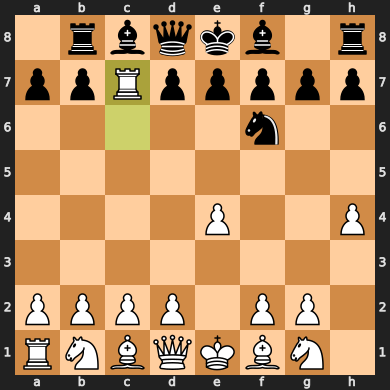

------
Bot's move: Qxc7

Current board:


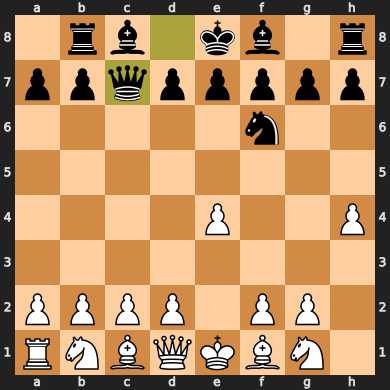

------
Your move (in UCI format, e.g., e2e4): a2a3

Current board:


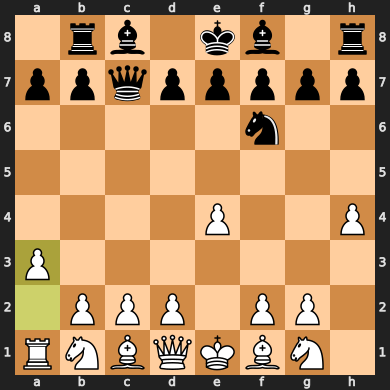

------
Bot's move: Kd8

Current board:


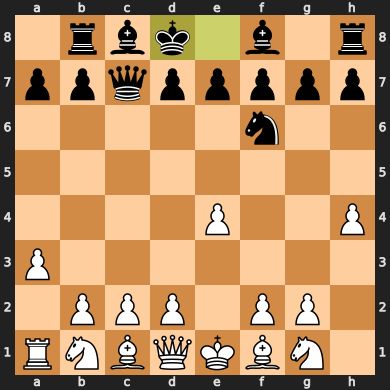

------
Your move (in UCI format, e.g., e2e4): a3a4

Current board:


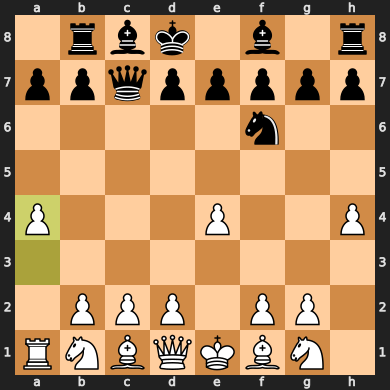

------
Bot's move: Ke8

Current board:


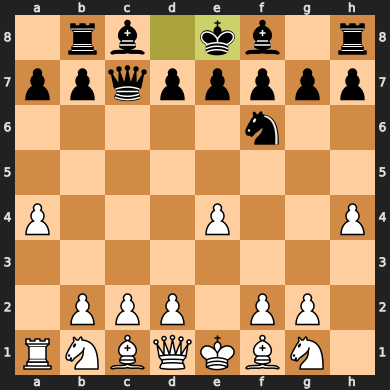

------
Your move (in UCI format, e.g., e2e4): a1a3

Current board:


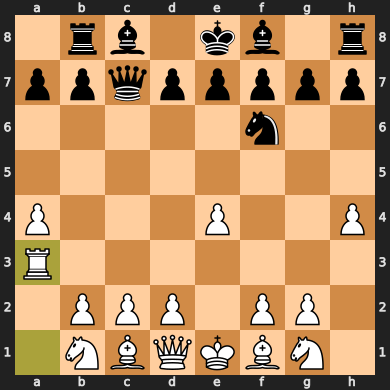

------
Bot's move: Kd8

Current board:


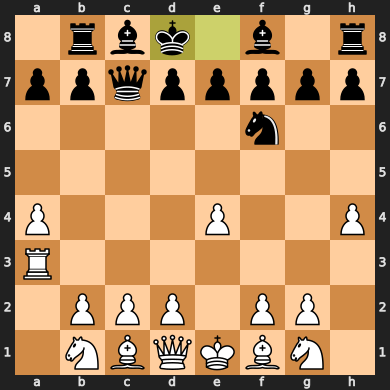

------
Your move (in UCI format, e.g., e2e4): a3c3

Current board:


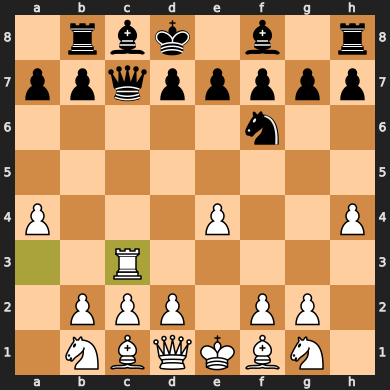

------
Bot's move: Ke8

Current board:


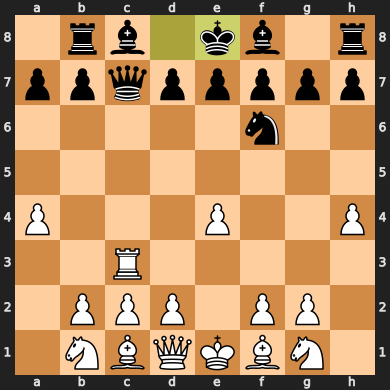

------
Your move (in UCI format, e.g., e2e4): c3c5

Current board:


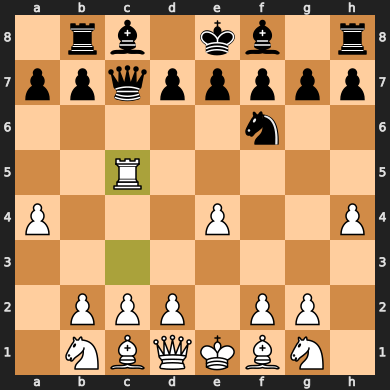

------
Bot's move: Kd8

Current board:


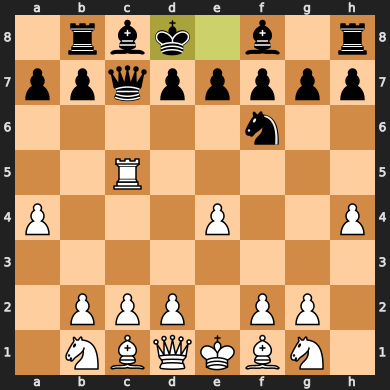

------
Your move (in UCI format, e.g., e2e4): c6c7
Illegal move. Try again.

Current board:


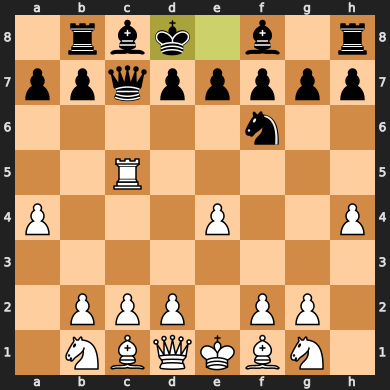

------
Your move (in UCI format, e.g., e2e4): c5c7

Current board:


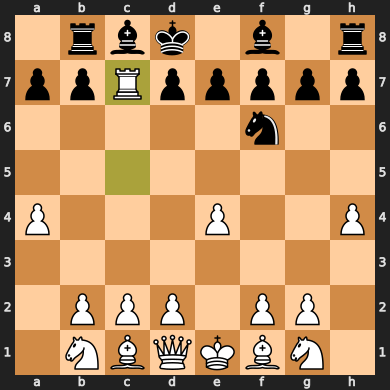

------
Bot's move: Ke8

Current board:


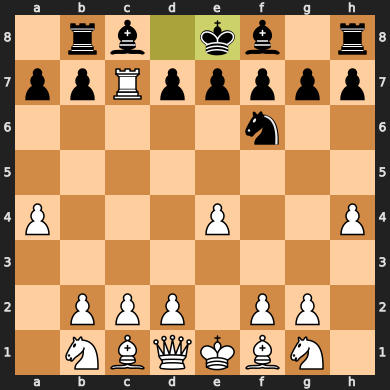

------
Your move (in UCI format, e.g., e2e4): c7c8

Current board:


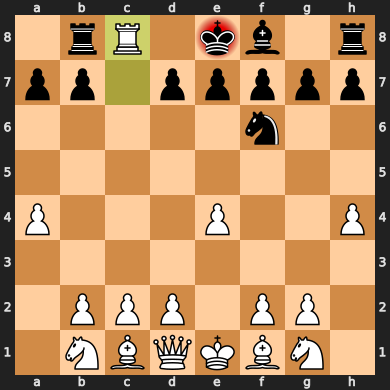

------
Bot's move: Rxc8

Current board:


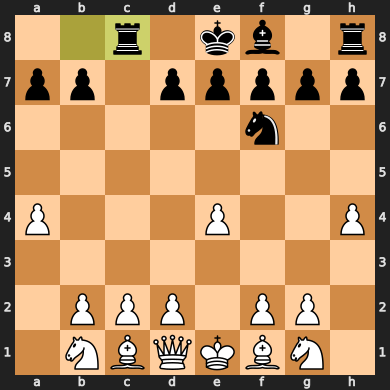

------
Your move (in UCI format, e.g., e2e4): d2d3

Current board:


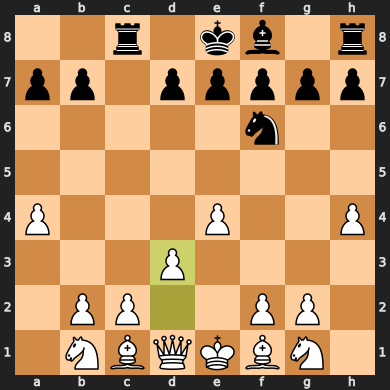

------
Bot's move: Kd8

Current board:


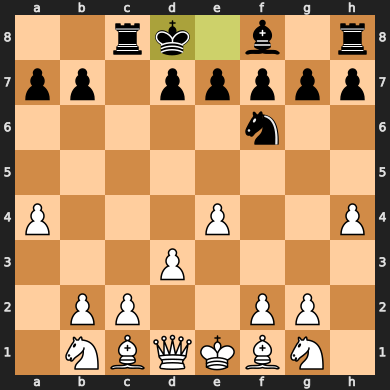

------
Your move (in UCI format, e.g., e2e4): d1f4
Illegal move. Try again.

Current board:


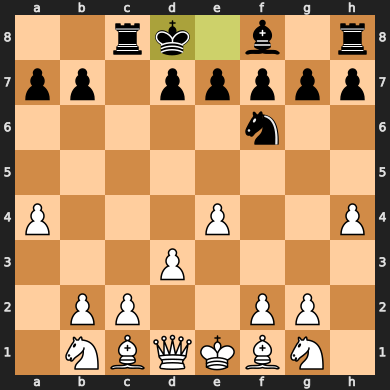

------
Your move (in UCI format, e.g., e2e4): d1f3

Current board:


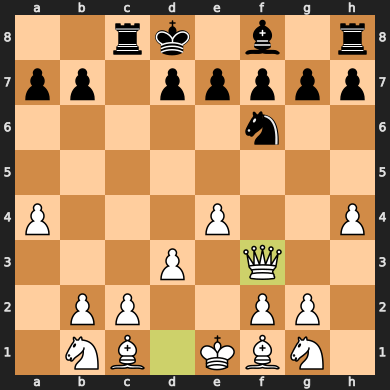

------
Bot's move: Ke8

Current board:


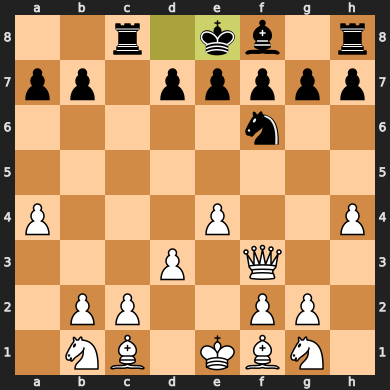

------
Your move (in UCI format, e.g., e2e4): f3f5

Current board:


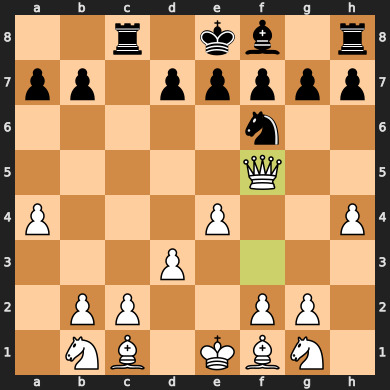

------
Bot's move: Kd8

Current board:


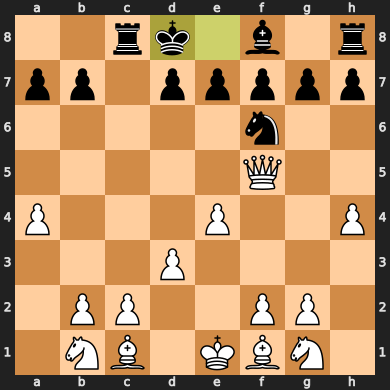

------
Your move (in UCI format, e.g., e2e4): f5c5

Current board:


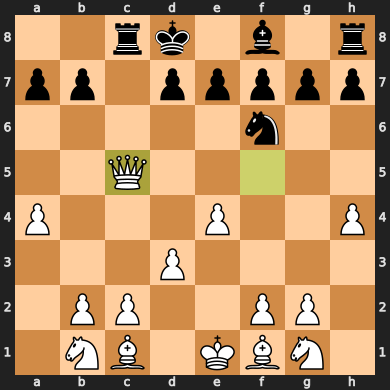

------
Bot's move: Ke8

Current board:


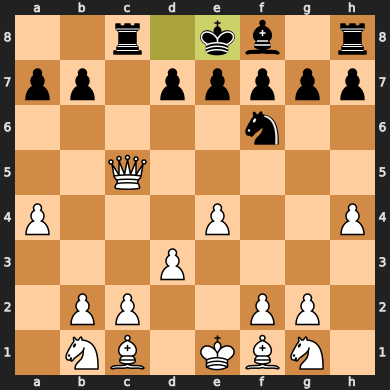

------
Your move (in UCI format, e.g., e2e4): c5c8

Final board:


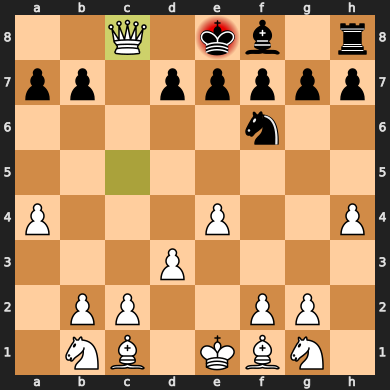

Game over. Result: 1-0


In [6]:
# Play against bot
bot.play_game()